In [9]:
import zipfile
import os

zip_path = "/content/store-sales-time-series-forecasting.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

print("Files/folders in /content after extraction:")
print(os.listdir("/content"))


Files/folders in /content after extraction:
['.config', 'transactions.csv', 'sample_submission.csv', '.ipynb_checkpoints', 'store-sales-time-series-forecasting.zip', 'train.csv', 'holidays_events.csv', 'test.csv', 'oil.csv', 'stores.csv', 'sample_data']


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")


In [12]:
base_path = "/content"

train = pd.read_csv(base_path + "/train.csv")
test = pd.read_csv(base_path + "/test.csv")
stores = pd.read_csv(base_path + "/stores.csv")
oil = pd.read_csv(base_path + "/oil.csv")
holidays = pd.read_csv(base_path + "/holidays_events.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Stores shape:", stores.shape)


Train shape: (3000888, 6)
Test shape: (28512, 5)
Stores shape: (54, 5)


In [13]:
# Convert date columns to datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

print("Date conversion done")


Date conversion done


In [14]:
# Check missing oil values
print("Missing oil prices:", oil['dcoilwtico'].isna().sum())

# Forward fill missing values
oil['dcoilwtico'] = oil['dcoilwtico'].ffill()

print("Missing after fill:", oil['dcoilwtico'].isna().sum())


Missing oil prices: 43
Missing after fill: 1


In [15]:
# Merge store metadata
train = train.merge(stores, on='store_nbr', how='left')
test = test.merge(stores, on='store_nbr', how='left')

# Merge oil prices
train = train.merge(oil, on='date', how='left')
test = test.merge(oil, on='date', how='left')

print("Merging done")
print(train.shape)


Merging done
(3000888, 11)


In [16]:
holidays_simple = holidays[['date', 'type']].copy()
holidays_simple['is_holiday'] = 1

train = train.merge(holidays_simple[['date', 'is_holiday']], on='date', how='left')
test = test.merge(holidays_simple[['date', 'is_holiday']], on='date', how='left')

train['is_holiday'] = train['is_holiday'].fillna(0)
test['is_holiday'] = test['is_holiday'].fillna(0)


In [17]:
def add_time_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
    return df

train = add_time_features(train)
test = add_time_features(test)
""

''

In [18]:
train['earthquake_effect'] = 0
train.loc[
    (train['date'] >= '2016-04-16') & (train['date'] <= '2016-05-31'),
    'earthquake_effect'
] = 1

test['earthquake_effect'] = 0


In [19]:
daily_sales = train.groupby('date')['sales'].sum().reset_index()


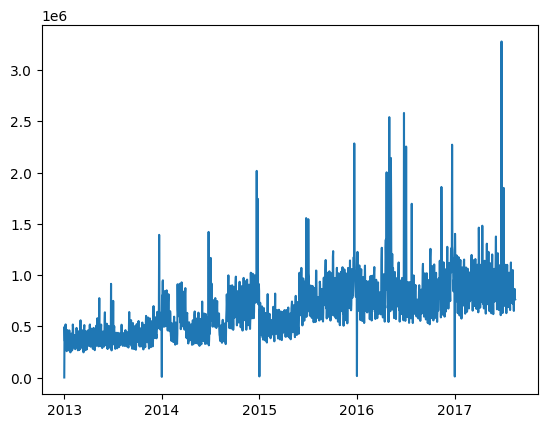

In [20]:
plt.figure()
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.show()


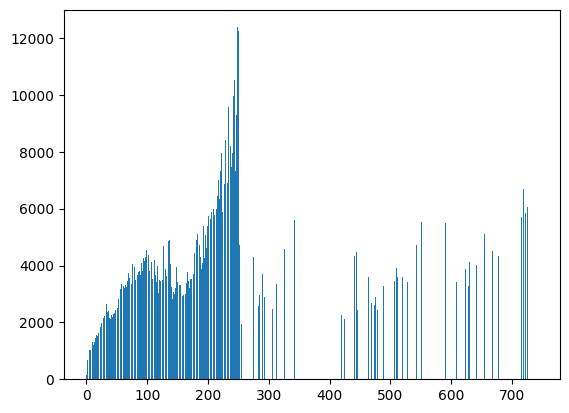

In [21]:
promo_sales = train.groupby('onpromotion')['sales'].mean().reset_index()

plt.figure()
plt.bar(promo_sales['onpromotion'], promo_sales['sales'])
plt.show()


In [22]:
features = [
    'onpromotion',
    'dcoilwtico',
    'is_holiday',
    'is_weekend',
    'earthquake_effect',
    'year',
    'month',
    'day',
    'dayofweek'
]


In [23]:
sample_train = train.sample(n=500000, random_state=42)

X_train = sample_train[features]
y_train = sample_train['sales']


In [24]:
model = RandomForestRegressor(
    n_estimators=50,
    max_depth=15,
    n_jobs=-1,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestRegressor(max_depth=15, n_estimators=50, n_jobs=-1, random_state=42)

In [25]:
val_data = train[train['date'] >= '2017-01-01']

X_val = val_data[features]
y_val = val_data['sales']

val_preds = model.predict(X_val)


In [26]:
mae = mean_absolute_error(y_val, val_preds)
mae


353.411454001693

In [27]:
X_test = test[features]
test_preds = model.predict(X_test)


In [28]:
submission = pd.DataFrame({
    'id': test['id'],
    'sales': test_preds
})

submission.to_csv("submission.csv", index=False)


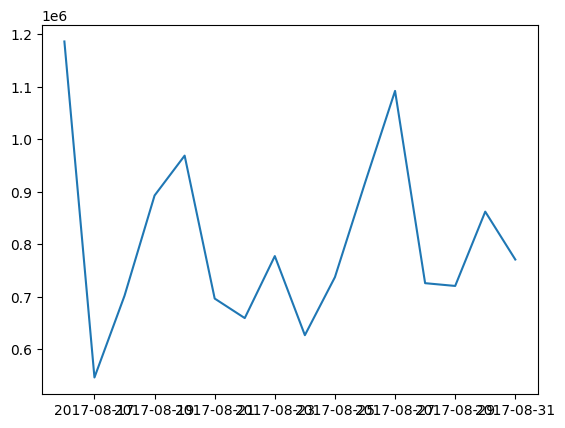

In [29]:
forecast = test.copy()
forecast['predicted_sales'] = test_preds

future_daily = forecast.groupby('date')['predicted_sales'].sum().reset_index()

plt.figure()
plt.plot(future_daily['date'], future_daily['predicted_sales'])
plt.show()


In [30]:
historical_daily = train.groupby('date')['sales'].sum().reset_index()
historical_daily.to_csv("historical_sales.csv", index=False)

future_daily.to_csv("future_sales_forecast.csv", index=False)


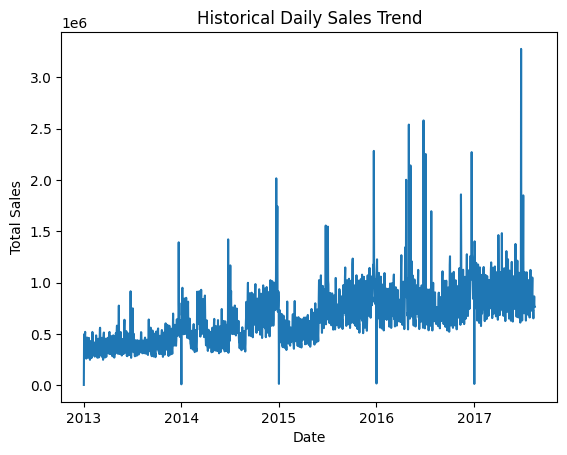

In [31]:
historical_daily = train.groupby('date')['sales'].sum().reset_index()

plt.figure()
plt.plot(historical_daily['date'], historical_daily['sales'])
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Historical Daily Sales Trend")
plt.show()


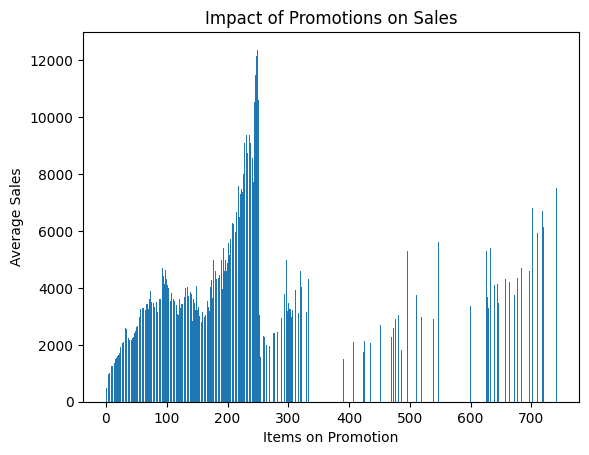

In [32]:
promo_effect = train.groupby('onpromotion')['sales'].mean().reset_index()

plt.figure()
plt.bar(promo_effect['onpromotion'], promo_effect['sales'])
plt.xlabel("Items on Promotion")
plt.ylabel("Average Sales")
plt.title("Impact of Promotions on Sales")
plt.show()


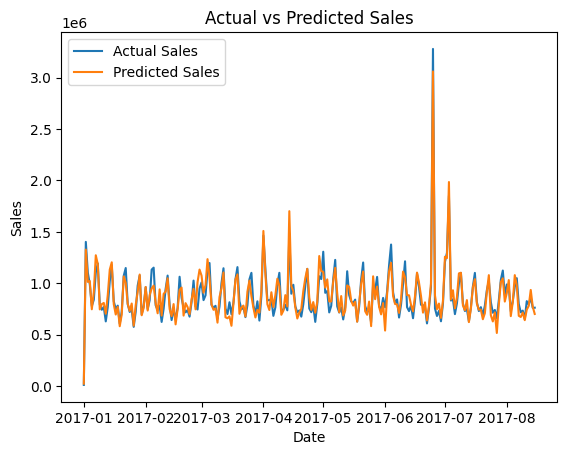

In [33]:
val_compare = val_data.copy()
val_compare['predicted_sales'] = val_preds

daily_actual = val_compare.groupby('date')['sales'].sum().reset_index()
daily_pred = val_compare.groupby('date')['predicted_sales'].sum().reset_index()

plt.figure()
plt.plot(daily_actual['date'], daily_actual['sales'], label="Actual Sales")
plt.plot(daily_pred['date'], daily_pred['predicted_sales'], label="Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Actual vs Predicted Sales")
plt.legend()
plt.show()


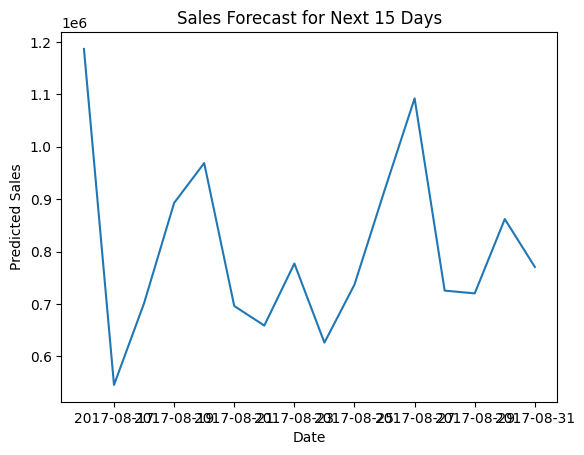

In [34]:
plt.figure()
plt.plot(future_daily['date'], future_daily['predicted_sales'])
plt.xlabel("Date")
plt.ylabel("Predicted Sales")
plt.title("Sales Forecast for Next 15 Days")
plt.show()


In [35]:
print("Mean Absolute Error (MAE):", mae)


Mean Absolute Error (MAE): 353.411454001693
